In [1]:
%matplotlib inline
import os
from pathlib import Path
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.metrics import classification_report, confusion_matrix
from logging import getLogger
import seaborn as sns
import matplotlib.pyplot as plt

from src.models.utils import callbacks
from src.preprocessing.computer_vision import augmentation, scaling
from src.projects.eurosat.architecture import FCNNetwork, CNNNetwork, CnnResBlock, GANDiscriminator, GAN, GANGenerator

2023-01-19 21:09:39.759480: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-19 21:09:40.593273: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.0: cannot open shared object file: No such file or directory
2023-01-19 21:09:40.593485: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvrtc.so.11.0: cannot open shared object file: No such file or directory
2023-01-19 21:09:40.593496: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia 

In [2]:
_log = getLogger()
generic_path = Path(os.getcwd()) / Path('trained_models')
specific_name = Path('eurosat')
model_save_fp = generic_path / specific_name
tensorboard_logdir = generic_path / Path('tensorboard_logs') / specific_name
checkpoint_logdir = model_save_fp / Path('checkpoints')

In [3]:
input_train_dataset, validation_dataset, test_dataset = tfds.load(
    "eurosat/rgb", as_supervised=True, split=["train[:75%]", "train[75%:90%]", "train[90%:]"]
)
_, info = tfds.load(
    "eurosat/rgb", as_supervised=True, with_info=True,
)

2023-01-19 21:09:42.823348: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-19 21:09:43.372485: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22333 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:c3:00.0, compute capability: 8.6


In [4]:
# Labels
class_names = info.features["label"].names
print(class_names)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


Plotting some random images with their label

In [4]:
def plot_random_images(dataset: tf.data.Dataset, sample_size :int):
    random_images = []
    sqrt_sample = int(np.sqrt(sample_size))

    for el in dataset.shuffle(1000).take(sqrt_sample*sqrt_sample):
        image, label = el
        label_name = class_names[label.numpy()]
        random_images.append((label_name, image))

    fig, axs = plt.subplots(nrows=sqrt_sample, ncols=sqrt_sample, figsize=(12, 12))
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle("Sample Images", fontsize=14, y=0.95)

    for img_tuple, ax in zip(random_images, axs.ravel()):
        label, img = img_tuple
        ax.imshow(img)
        ax.set_title(label)
    plt.show()


2023-01-19 21:07:18.492693: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


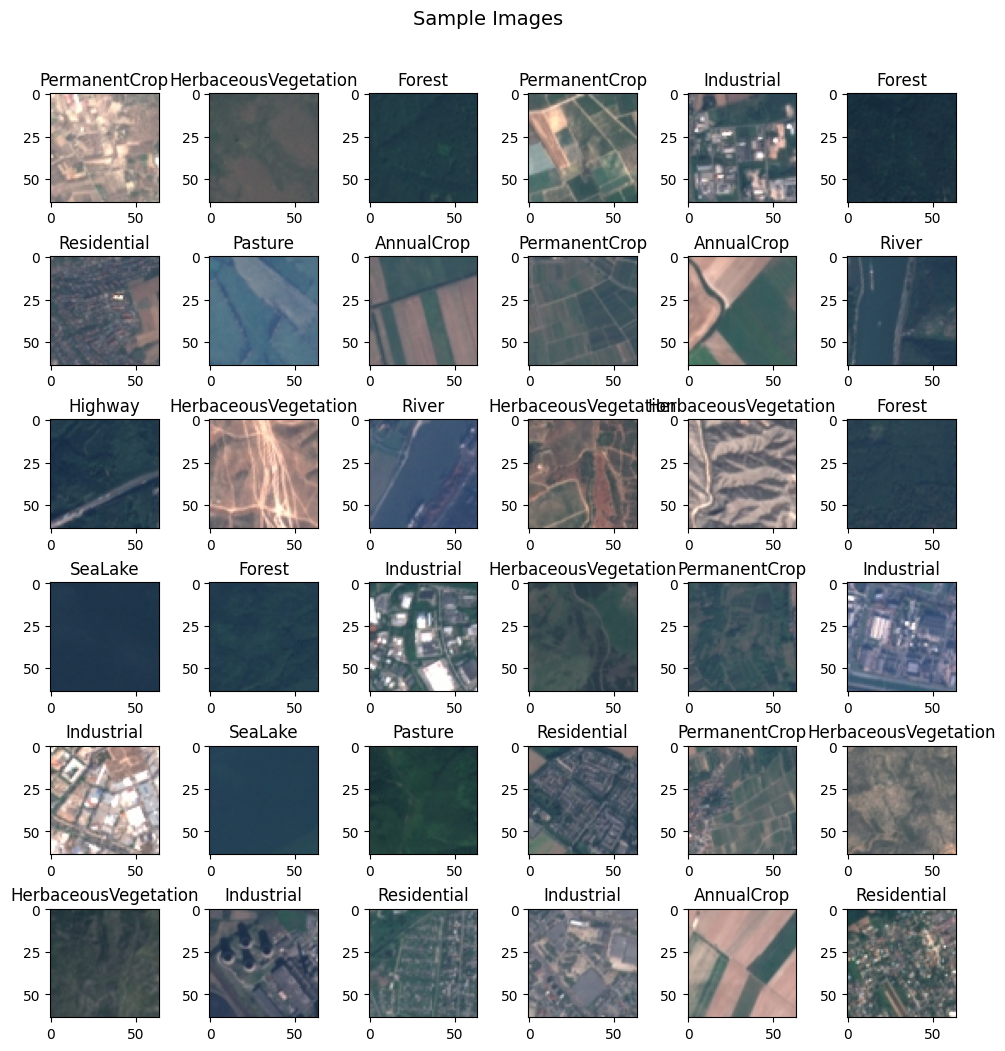

In [6]:
plot_random_images(input_train_dataset, 36)

The next steps will be about preprocessing the images: we will randomly flip them, adjust the brightness and the contrast. Since all images have the same size we don't need to crop or resize them

In [7]:
train_dataset = input_train_dataset.map(lambda image, label: (augmentation(image), label))
train_dataset = train_dataset.map(lambda image, label: (scaling(image), label))
validation_dataset = validation_dataset.map(lambda image, label: (scaling(image), label))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [8]:
batch_size = 64
train_dataset = train_dataset.shuffle(2000, reshuffle_each_iteration=True).repeat().batch(batch_size).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.repeat().batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Classification problem: labelling the images correctly

We will now train two similar models, one that has a final Dense layer ('CNNNetwork'), and another that is a fully connected CNN network where the final output layer is also a convolutional one, with a Global Max Pooling layer.

The goal is to classify the images correctly. After training, the performance of the models will be measured against the test dataset.

Model: "CNNNetwork"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        2432      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                      

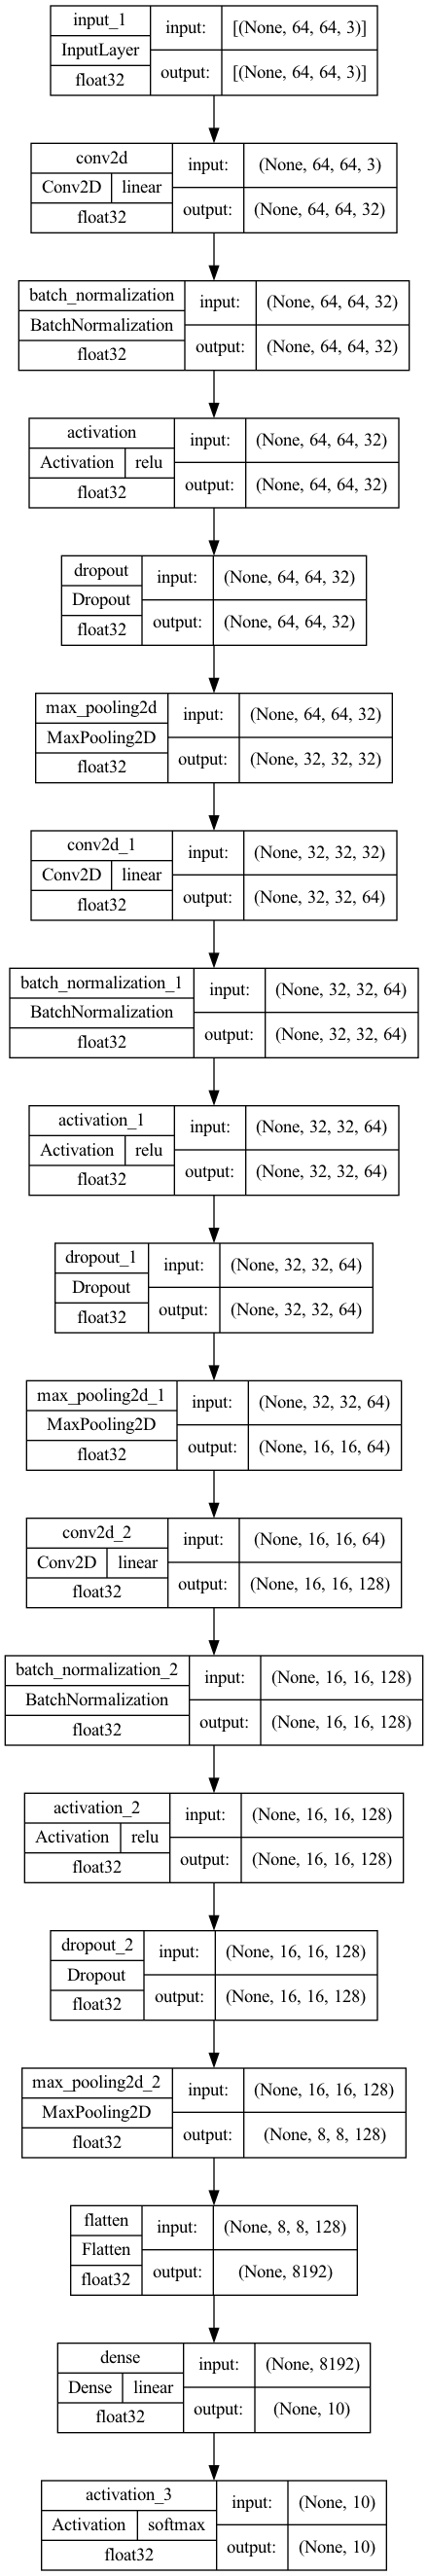

In [9]:
name = 'CNNNetwork'
artifacts_path = model_save_fp / Path(name)
tensorboard_run_path = tensorboard_logdir / Path(name) / Path(str(datetime.datetime.now()))
model = CNNNetwork(name=name, filepath=artifacts_path)
model = model.connect_layers()

In [10]:
epochs = 100
model.fit(
    x=train_dataset, 
    validation_data=validation_dataset, 
    epochs=epochs, 
    callbacks=callbacks(
        checkpoint_logdir=checkpoint_logdir,
        tensorboard_logdir=str(tensorboard_run_path)
    ),
    steps_per_epoch=1200,
    validation_steps=1200,
)
model.save(artifacts_path)
_log.info(f"Saved {model.name} in folder {artifacts_path}")

Epoch 1/100


2022-12-16 21:25:03.970193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1200/1200 [==============================] - ETA: 0s - loss: 1.4459 - accuracy: 0.5491

2022-12-16 21:25:30.725902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: saving model to /Users/gianrond/git/deeplearning/trained_models/eurosat/checkpoints/weights.01-1.30.hdf5
1200/1200 [==============================] - 39s 32ms/step - loss: 1.4459 - accuracy: 0.5491 - val_loss: 1.2965 - val_accuracy: 0.4968 - lr: 0.0010
Epoch 2/100
1198/1200 [============================>.] - ETA: 0s - loss: 0.8738 - accuracy: 0.6962
Epoch 2: saving model to /Users/gianrond/git/deeplearning/trained_models/eurosat/checkpoints/weights.02-0.86.hdf5
1200/1200 [==============================] - 37s 31ms/step - loss: 0.8737 - accuracy: 0.6962 - val_loss: 0.8576 - val_accuracy: 0.6977 - lr: 0.0010
Epoch 3/100
1199/1200 [============================>.] - ETA: 0s - loss: 0.6501 - accuracy: 0.7692
Epoch 3: saving model to /Users/gianrond/git/deeplearning/trained_models/eurosat/checkpoints/weights.03-1.20.hdf5
1200/1200 [==============================] - 37s 30ms/step - loss: 0.6500 - accuracy: 0.7693 - val_loss: 1.1981 - val_accuracy: 0.5676 - lr: 0.0010
Epoch 4/100
120

INFO:tensorflow:Assets written to: /Users/gianrond/git/deeplearning/trained_models/eurosat/CNNNetwork/assets


INFO:tensorflow:Assets written to: /Users/gianrond/git/deeplearning/trained_models/eurosat/CNNNetwork/assets


Model: "FCNNetwork"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 32)    2432      
                                                                 
 batch_normalization_3 (Batc  (None, None, None, 32)   128       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, None, None, 32)    0         
                                                                 
 dropout_3 (Dropout)         (None, None, None, 32)    0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, None, None, 32)   0         
 2D)                                                    

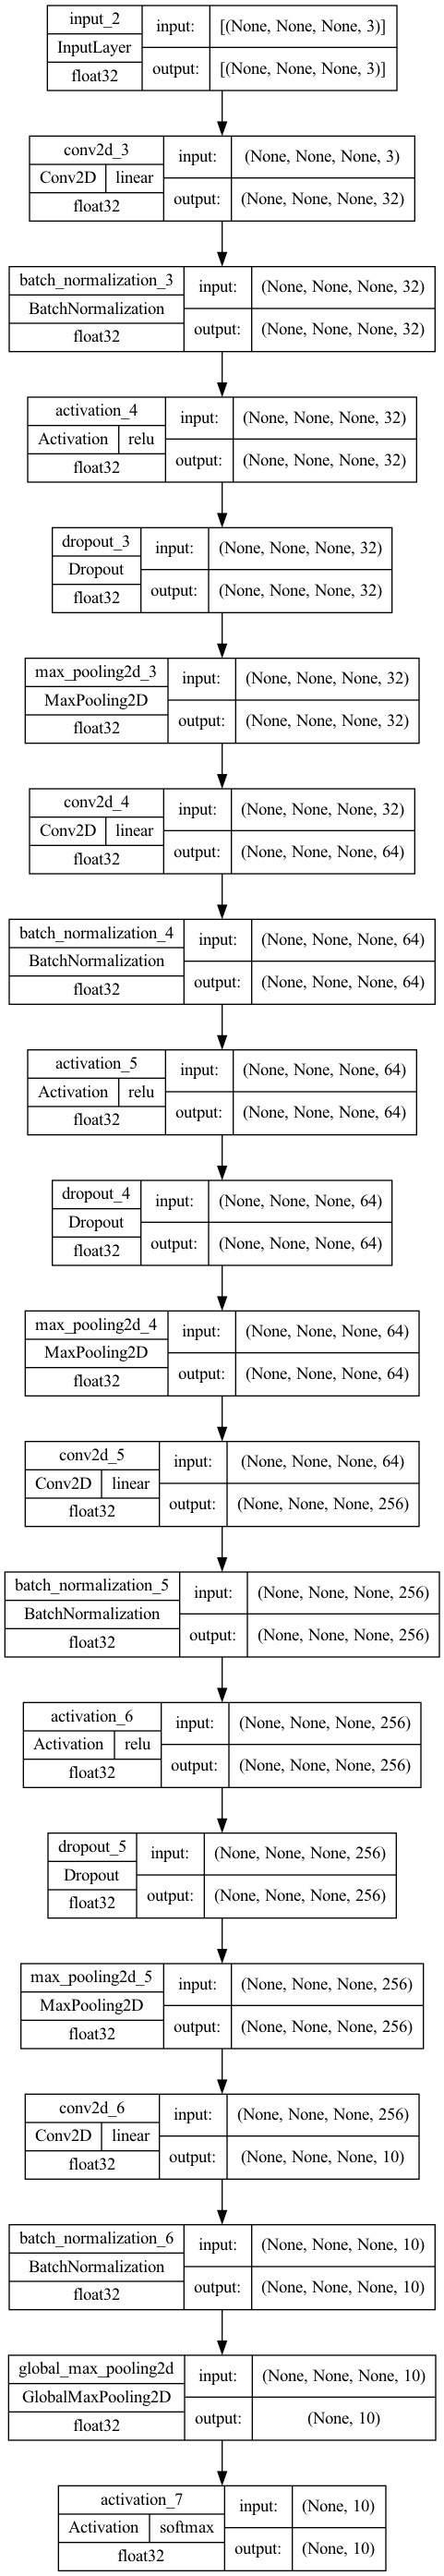

In [10]:
name = 'FCNNetwork'
artifacts_path = model_save_fp / Path(name)
tensorboard_run_path = tensorboard_logdir / Path(name) / Path(str(datetime.datetime.now()))
model = FCNNetwork(name=name, filepath=artifacts_path)
model = model.connect_layers()

In [2]:
epochs = 100
model.fit(
    x=train_dataset, 
    validation_data=validation_dataset, 
    epochs=epochs, 
    callbacks=callbacks(str(tensorboard_run_path)),
    steps_per_epoch=1200,
    validation_steps=1200,
)
model.save(artifacts_path)
_log.info(f"Saved {model.name} in folder {artifacts_path}")

NameError: name 'model' is not defined

Now that the models have been trained, we can check the performance of both of them against the test set

In [9]:
test_dataset = test_dataset.map(lambda image, label: (scaling(image), label))
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [10]:
model_paths = {
    'FCNNetwork': model_save_fp / Path('FCNNetwork'),
    'CNNNetwork': model_save_fp / Path('CNNNetwork'),
}
loaded_models = {}
for model_name, model_path in model_paths.items():
    loaded_models[model_name] = tf.tf.kerasmodels.load_model(model_path)

*** Model: FCNNetwork ***


2022-12-17 09:03:04.639636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/85 [==========>...................] - ETA: 0s

2022-12-17 09:03:05.856755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


85/85 [==============================] - 1s 6ms/step


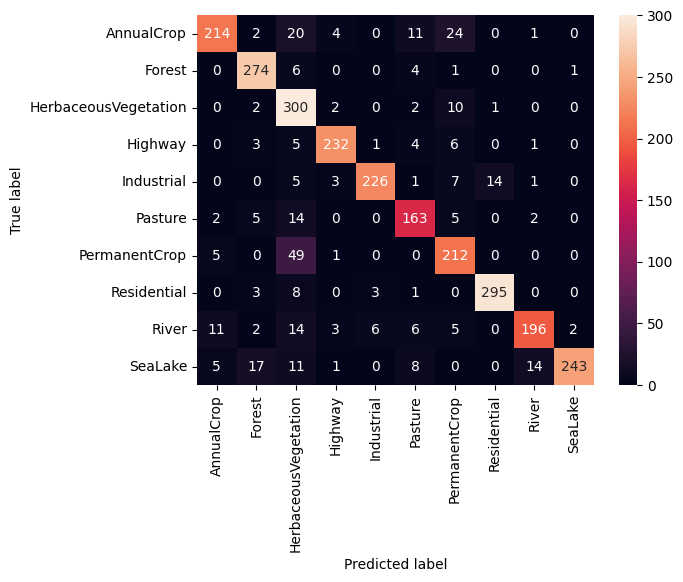

              precision    recall  f1-score   support

           0       0.90      0.78      0.83       276
           1       0.89      0.96      0.92       286
           2       0.69      0.95      0.80       317
           3       0.94      0.92      0.93       252
           4       0.96      0.88      0.92       257
           5       0.81      0.85      0.83       191
           6       0.79      0.79      0.79       267
           7       0.95      0.95      0.95       310
           8       0.91      0.80      0.85       245
           9       0.99      0.81      0.89       299

    accuracy                           0.87      2700
   macro avg       0.88      0.87      0.87      2700
weighted avg       0.88      0.87      0.87      2700

*** Model: CNNNetwork ***
14/85 [===>..........................] - ETA: 0s - loss: 0.2065 - accuracy: 0.9330

2022-12-17 09:03:06.713745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/85 [==========>...................] - ETA: 0s

2022-12-17 09:03:07.523631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


85/85 [==============================] - 1s 5ms/step


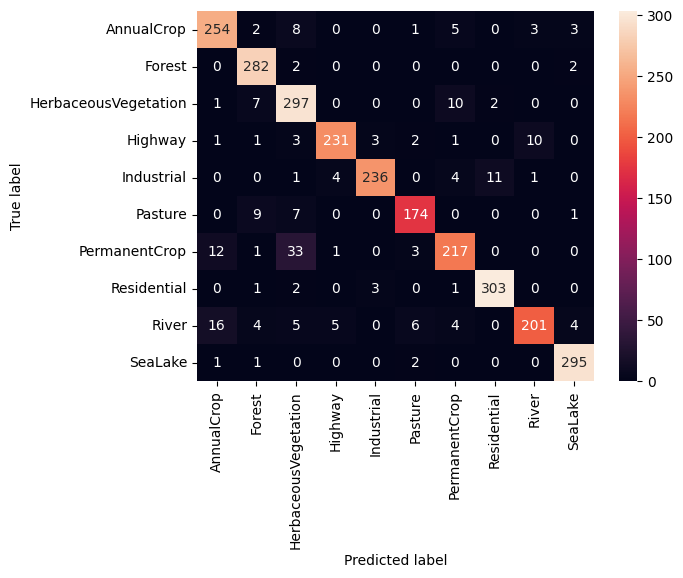

              precision    recall  f1-score   support

           0       0.89      0.92      0.91       276
           1       0.92      0.99      0.95       286
           2       0.83      0.94      0.88       317
           3       0.96      0.92      0.94       252
           4       0.98      0.92      0.95       257
           5       0.93      0.91      0.92       191
           6       0.90      0.81      0.85       267
           7       0.96      0.98      0.97       310
           8       0.93      0.82      0.87       245
           9       0.97      0.99      0.98       299

    accuracy                           0.92      2700
   macro avg       0.93      0.92      0.92      2700
weighted avg       0.92      0.92      0.92      2700

{'FCNNetwork': [0.45274844765663147, 0.8722222447395325], 'CNNNetwork': [0.2188558131456375, 0.9222221970558167]}


In [11]:
accuracies = {}
y_test = np.array(list(test_dataset.map(lambda x, y: y).unbatch().as_numpy_iterator()))
for model_name, model in loaded_models.items():
    print(f'*** Model: {model_name} ***')
    accuracies[model_name] = model.evaluate(test_dataset)
    y_pred = model.predict(test_dataset)
    y_pred_argmax = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_test, y_pred_argmax)
    plt.figure()
    plot = sns.heatmap(pd.DataFrame(cm, index=class_names, columns=class_names), annot=True, fmt='g')
    title = f"Confusion matrix - {model_name}"
    plot.set_title('')
    plot.set_xlabel('Predicted label')
    plot.set_ylabel('True label')
    plt.show()

    cr = classification_report(y_test, y_pred_argmax)
    print(cr)
print(accuracies)

The accuracy on the test set confirms what we have seen on the validation data: the CNN-Network outperforms the FCN Network in this case, achieving 93% and 87% accuracy respectively.

Both models seem to have the hardest time to distinguish the "Herbaceous Vegetation" from the "Permanent Crop". It's likely that humans would also have a hard time to tell the two classes apart.

Below are same samples from the two classes:

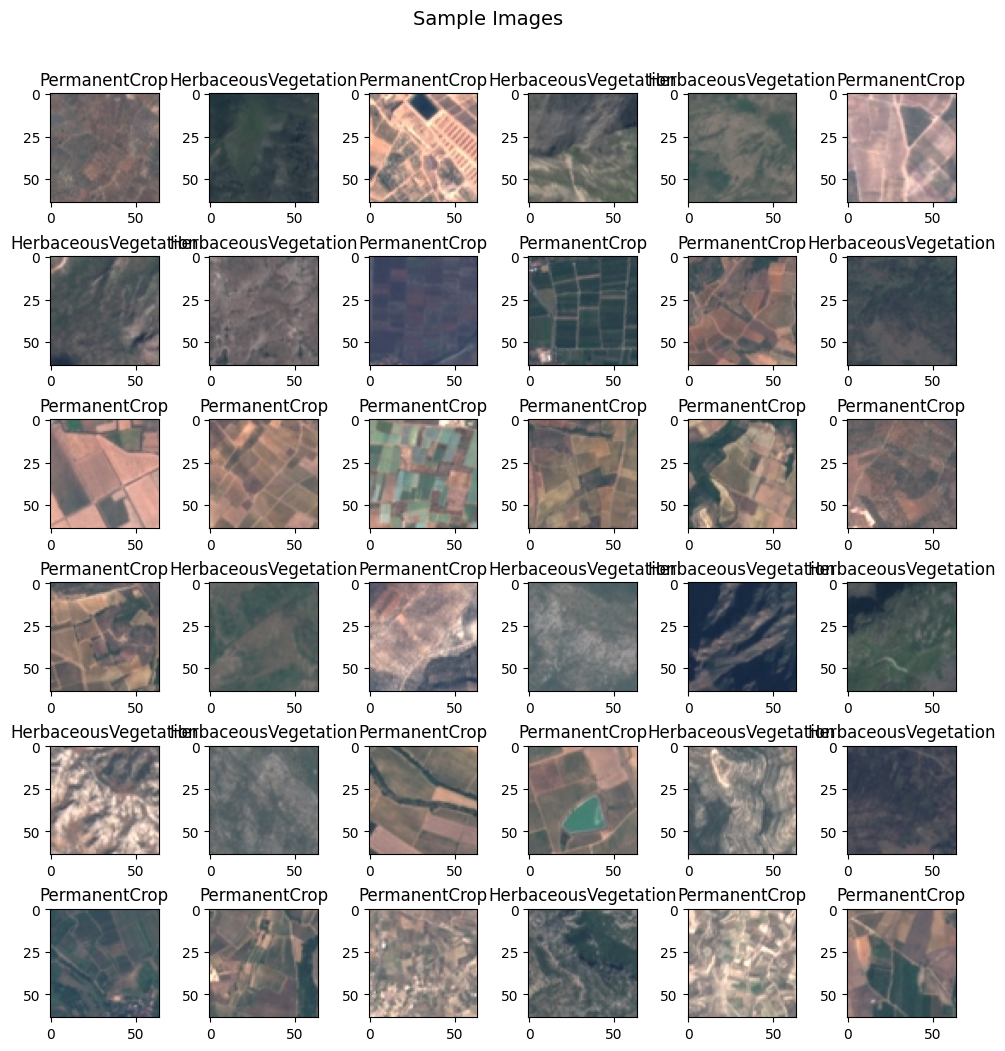

In [12]:
def filter_classes(y_label, y_labels_to_keep):
    return tf.cond(
        tf.math.reduce_any(tf.math.equal(y_label, tf.constant(y_labels_to_keep, dtype=tf.int64))),
        lambda: True,
        lambda: False,
    )
filtered_test_ds = test_dataset.unbatch().filter(lambda x, y: filter_classes(y, [2, 6]))
plot_random_images(filtered_test_ds, 36)

The picture above shows the most two classes that the CNNNetwork model seems to confuse the most. Still, out of the 267 PermanentCrop samples, 235 are correctly labelled. Out of the remaining 32 errors, 21 are (wrongly) attributed to the HerbaceousVegetation class.

It's finally worth keeping in mind that nor of the two models has been gridsearched and fine tuned to achieve the best performance, so it's likely that there is still room for improvement.

# Generating new images with GANs architectures

After having tackled the classification problem, we will now attempt to train a GAN to generate random images given the input label.

We will now define a function to train a Deep Convolutional GAN model. We will simply scale the dataset for the purpose, but we won't be augmenting it since we want to generate realistic images.

In [5]:
def scale_for_tanh(tensor):
    return tensor * 2. - 1.

In [19]:
x_train_gan = input_train_dataset.map(lambda image, label: scaling(image), num_parallel_calls=tf.data.AUTOTUNE)
x_train_gan = x_train_gan.map(lambda x: scale_for_tanh(x), num_parallel_calls=tf.data.AUTOTUNE)
batch_size = 64
x_train_gan = x_train_gan.shuffle(2000, reshuffle_each_iteration=True).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

Building the Generator

In [20]:
CODINGS_SIZE = 100

name = 'GANGenerator'
artifacts_path = model_save_fp / Path(name)
tensorboard_run_path = tensorboard_logdir / Path(name) / Path(str(datetime.datetime.now()))
generator = GANGenerator(name=name, filepath=artifacts_path)
generator = generator.connect_layers(codings_size=CODINGS_SIZE)

Model: "GANGenerator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_2 (Dense)             (None, 16384)             1654784   
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 batch_normalization_3 (Batc  (None, 8, 8, 256)        1024      
 hNormalization)                                                 
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 16, 16, 256)      1638656   
 ranspose)                                                       
                                                                 
 activation_3 (Activation)   (None, 16, 16, 256)      

None

Building the Discriminator

In [21]:
name = 'GANDiscriminator'
artifacts_path = model_save_fp / Path(name)
tensorboard_run_path = tensorboard_logdir / Path(name) / Path(str(datetime.datetime.now()))
discriminator = GANDiscriminator(name=name, filepath=artifacts_path)
batch_input_shape = generator.output_shape
discriminator = discriminator.connect_layers(batch_input_shape=batch_input_shape)

Model: "GANDiscriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        2432      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 dropout_3 (Dropout)         (None, 32, 32, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 32)        25632     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 32)        0         
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 32)   

None

Combining Generator and Discriminator in the GAN model

In [22]:
name = 'GAN'
artifacts_path = model_save_fp / Path(name)
tensorboard_run_path = tensorboard_logdir / Path(name) / Path(str(datetime.datetime.now()))
gan_model = GAN(name=name, filepath=artifacts_path, generator=generator, discriminator=discriminator)
gan_model = gan_model.connect_layers(codings_size=CODINGS_SIZE)

Model: "GAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 100)]             0         
                                                                 
 GANGenerator (Functional)   (None, 64, 64, 3)         4954371   
                                                                 
 GANDiscriminator (Functiona  (None, 1)                55745     
 l)                                                              
                                                                 
Total params: 5,010,116
Trainable params: 4,952,835
Non-trainable params: 57,281
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


None

In [23]:
def plot_random_images(generator, codings_size, sample_size :int):
    random_input = tf.random.normal(shape=[sample_size, codings_size])
    batch_generated_images = generator.predict(random_input)

    sqrt_sample = int(np.sqrt(sample_size))

    fig, axs = plt.subplots(nrows=sqrt_sample, ncols=sqrt_sample, figsize=(12, 12))
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle("Sample Images", fontsize=14, y=0.95)

    for img, ax in zip(batch_generated_images, axs.ravel()):
        ax.imshow(img)
    plt.show()


tf.random.set_seed(42)
np.random.seed(42)

CODINGS_SIZE = 100

generator = tf.keras.models.Sequential([
    tf.keras.layers.Dense(8 * 8 * 256, input_shape=[CODINGS_SIZE]),
    tf.keras.layers.Reshape([8, 8, 256]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(256, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    tf.keras.layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])
generator.summary()
discriminator = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=5, strides=2, padding="SAME",
                        activation=tf.keras.layers.LeakyReLU(0.2),
                        input_shape=[64, 64, 3]),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(32, kernel_size=5, strides=2, padding="SAME",
                        activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Conv2D(32, kernel_size=5, strides=2, padding="SAME",
                        activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
discriminator.summary()
gan = tf.keras.models.Sequential([generator, discriminator])
gan.summary()

discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [24]:
def train_gan(gan_model, dataset, codings_size, epochs):
    generator = gan_model.layers[1]
    discriminator = gan_model.layers[2]

    for epoch in range(1, epochs + 1):
        discr_losses = []
        gan_losses = []
        for x_batch in dataset:
            # Step 1 - training the discriminator
            # Adding noise - the generator will never see actual data
            noise = tf.random.normal(shape=[batch_size, codings_size])
            fake_imgs = generator(noise)
            fake_and_real_img = tf.concat([fake_imgs, x_batch], axis=0)
            # Labelling 1 for real images and 0 for fake images
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            # Discriminator inside the gan is NOT trainable
            discriminator.trainable = True
            discr_loss = discriminator.train_on_batch(fake_and_real_img, y1, return_dict=True)
            discr_losses.append(discr_loss['loss'])

            # Step 2 - training the generator through the GAN
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan_loss = gan_model.train_on_batch(noise, y2, return_dict=True)
            gan_losses.append(gan_loss['loss'])
        
        plt.imshow(fake_imgs[0])
        plt.show()
        # plot_random_images(generator, codings_size, 9)
        
        mean_epoch_discr_loss = np.array(discr_losses).mean()
        mean_epoch_gan_loss = np.array(gan_losses).mean()
        print(f'Epoch {epoch} / {epochs} - Gan Loss {mean_epoch_gan_loss} | Discr loss {mean_epoch_discr_loss} ')
        discr_losses = []
        gan_losses = []

    
    return gan_model

2023-01-19 21:14:21.610315: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGANDiscriminator/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-01-19 21:14:22.631076: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inGAN/GANDiscriminator/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


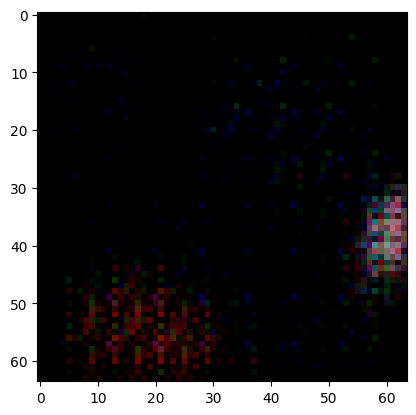

Epoch 1 / 50 - Gan Loss 1.8612608956379368 | Discr loss 0.5113322181815777 


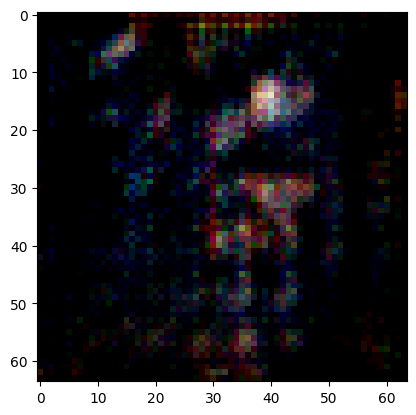

Epoch 2 / 50 - Gan Loss 1.9282642882081527 | Discr loss 0.4816568393283818 


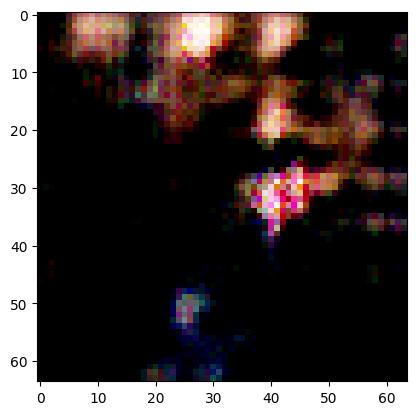

Epoch 3 / 50 - Gan Loss 1.4938633051476902 | Discr loss 0.606987823319586 


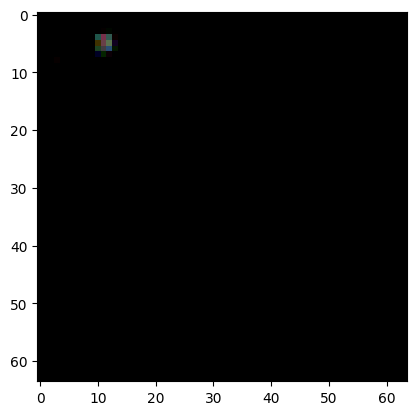

Epoch 4 / 50 - Gan Loss 1.0569947382694558 | Discr loss 0.6594793823889539 


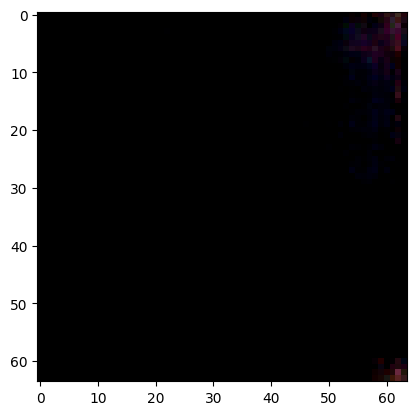

Epoch 5 / 50 - Gan Loss 0.8528357283035412 | Discr loss 0.6880021423478669 


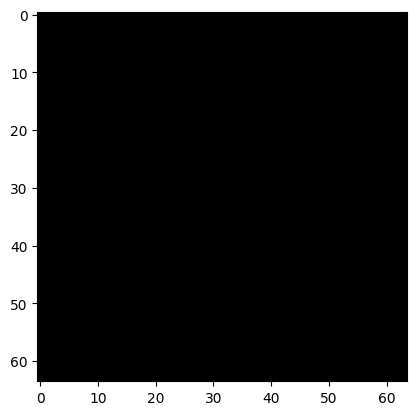

Epoch 6 / 50 - Gan Loss 0.808284871751749 | Discr loss 0.690081567703923 


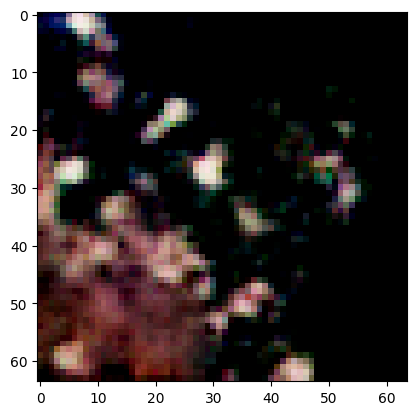

Epoch 7 / 50 - Gan Loss 0.8130789297290996 | Discr loss 0.6866044949127149 


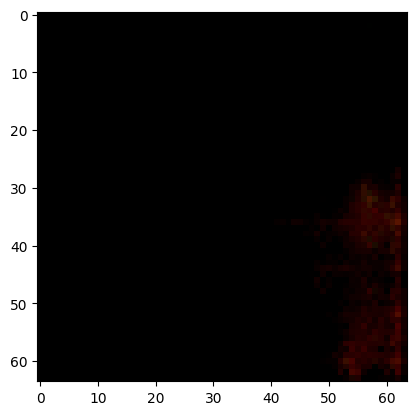

Epoch 8 / 50 - Gan Loss 0.8199087029726014 | Discr loss 0.6633253808640227 


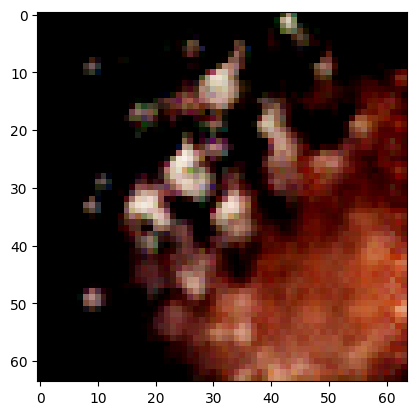

Epoch 9 / 50 - Gan Loss 1.1009127518007034 | Discr loss 0.6512783087695702 


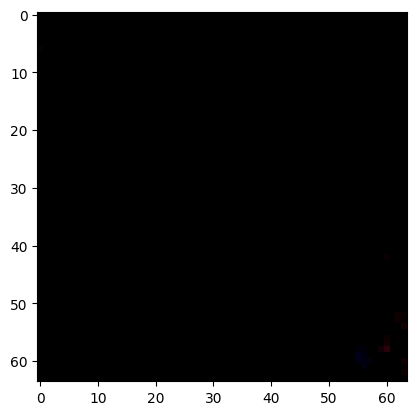

Epoch 10 / 50 - Gan Loss 1.0829900634703378 | Discr loss 0.6135171792835374 


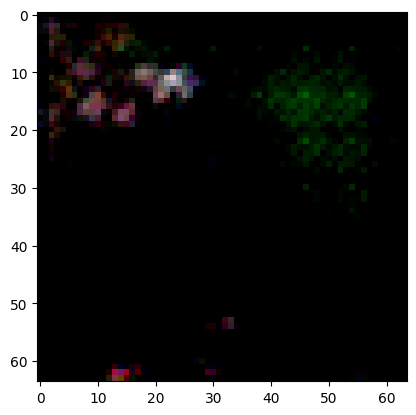

Epoch 11 / 50 - Gan Loss 1.3670706259627503 | Discr loss 0.47673200429535084 


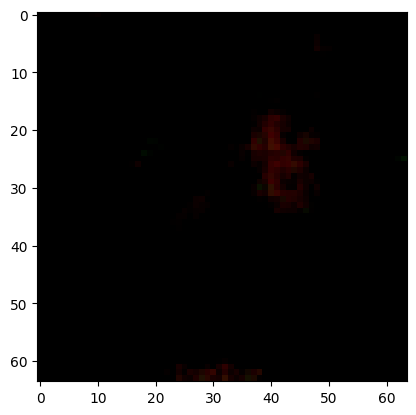

Epoch 12 / 50 - Gan Loss 0.7231944181287179 | Discr loss 0.5907971767496459 


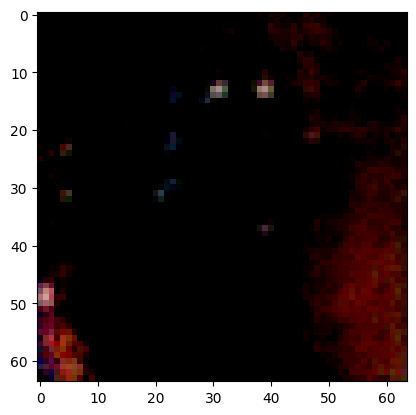

Epoch 13 / 50 - Gan Loss 0.47366642226492295 | Discr loss 0.44263963740837725 


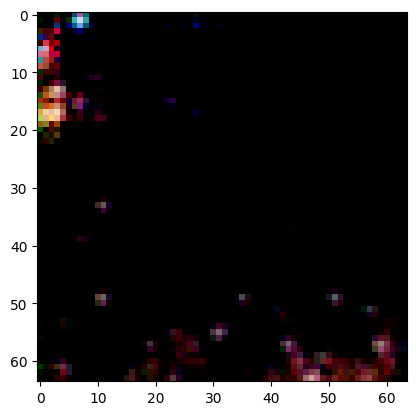

Epoch 14 / 50 - Gan Loss 0.7976042167623164 | Discr loss 0.4511174049723563 


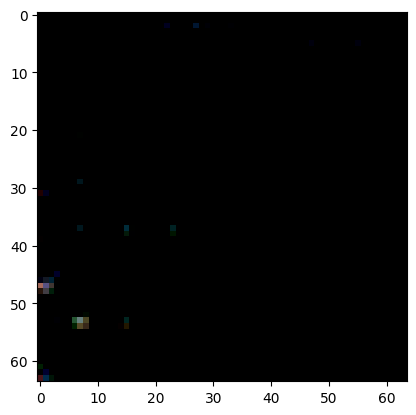

Epoch 15 / 50 - Gan Loss 0.6627190024760071 | Discr loss 0.4143781339737905 


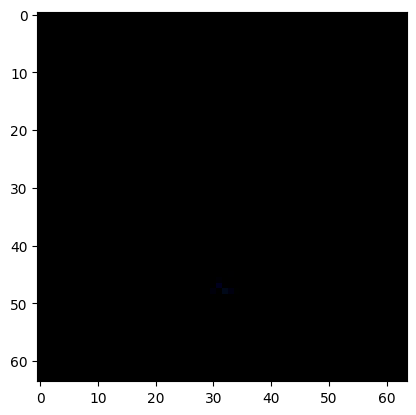

Epoch 16 / 50 - Gan Loss 1.7432627648632373 | Discr loss 0.2670975159492662 


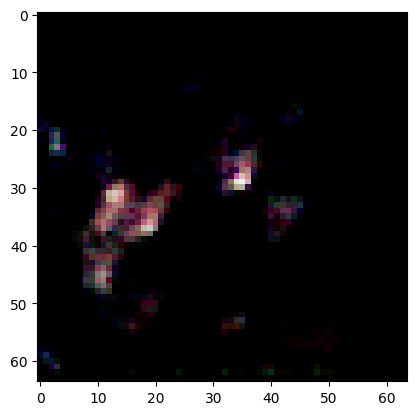

Epoch 17 / 50 - Gan Loss 1.0646523842731968 | Discr loss 0.4036608832671684 


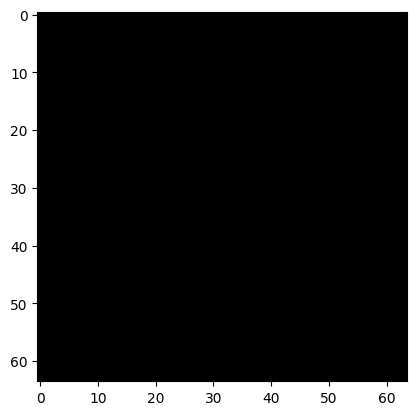

Epoch 18 / 50 - Gan Loss 0.7239996050644459 | Discr loss 0.5598224984316886 


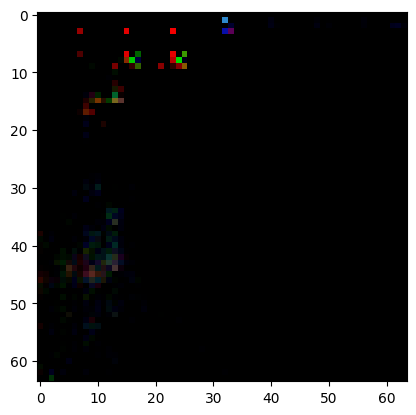

Epoch 19 / 50 - Gan Loss 1.2240703616924502 | Discr loss 0.35157161196575887 


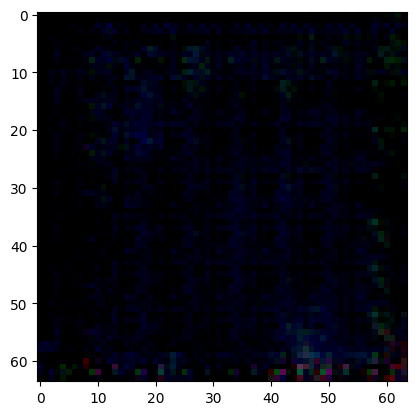

Epoch 20 / 50 - Gan Loss 1.4579062151894577 | Discr loss 0.2879849000726355 


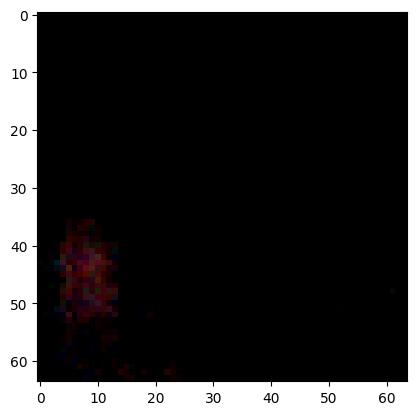

Epoch 21 / 50 - Gan Loss 1.0849624222083858 | Discr loss 0.48444957550651174 


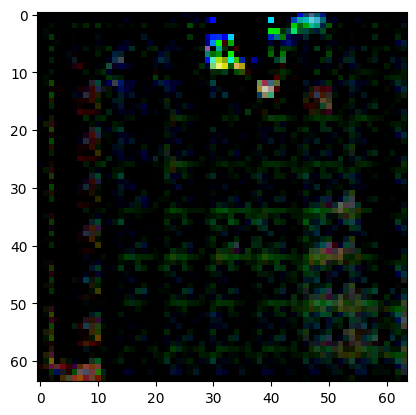

Epoch 22 / 50 - Gan Loss 1.2279380776144622 | Discr loss 0.2778447823277734 


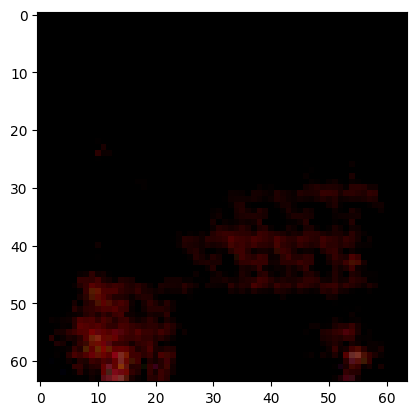

Epoch 23 / 50 - Gan Loss 2.1584897805546834 | Discr loss 0.3214758242704446 


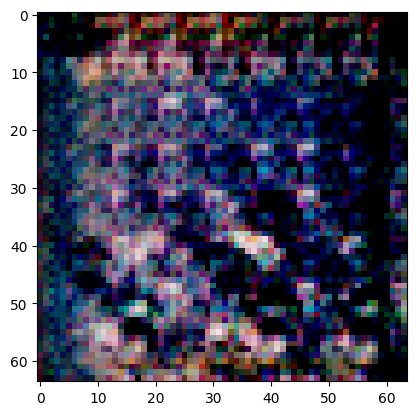

Epoch 24 / 50 - Gan Loss 2.0560450717531418 | Discr loss 0.32104449401337165 


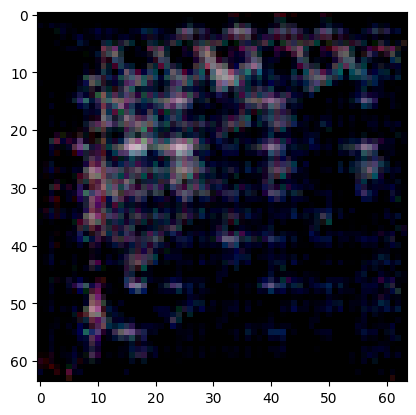

Epoch 25 / 50 - Gan Loss 1.8457848378447566 | Discr loss 0.25740047154396983 


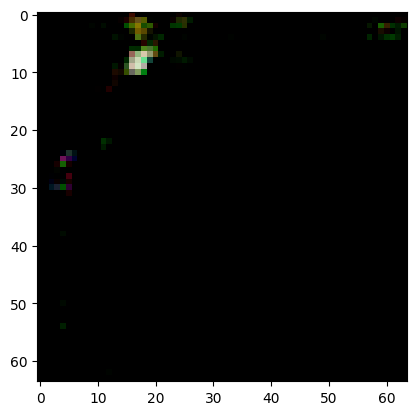

Epoch 26 / 50 - Gan Loss 0.9781438535962227 | Discr loss 0.2345383765026367 


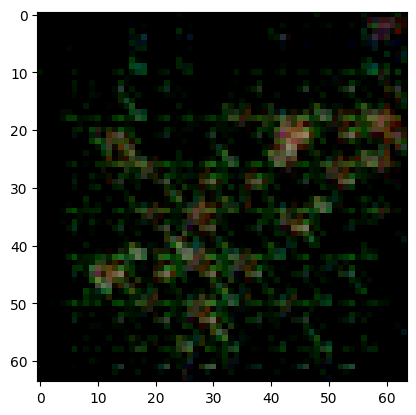

Epoch 27 / 50 - Gan Loss 1.1378111487756726 | Discr loss 0.4560872789743486 


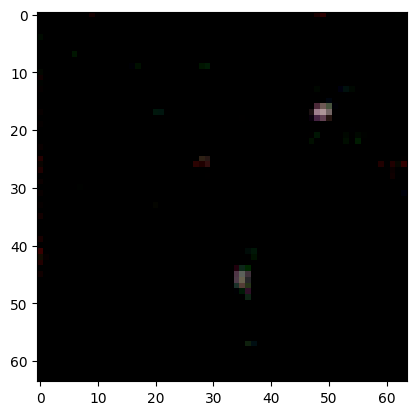

Epoch 28 / 50 - Gan Loss 0.9113736368317904 | Discr loss 0.4100565712993281 


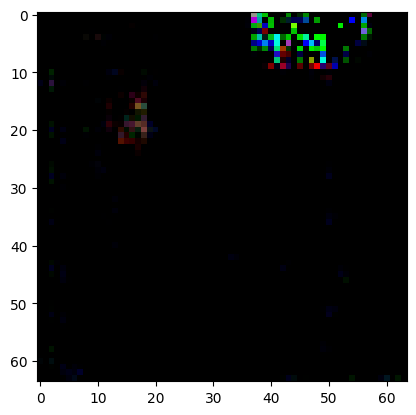

Epoch 29 / 50 - Gan Loss 0.390202506074882 | Discr loss 0.26568279237559367 


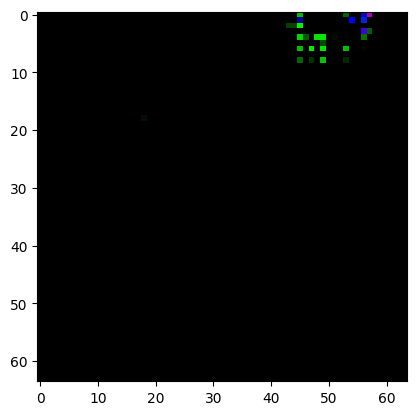

Epoch 30 / 50 - Gan Loss 0.7591824111303078 | Discr loss 0.3212956126825 


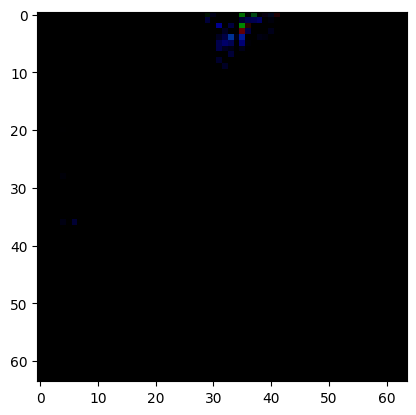

Epoch 31 / 50 - Gan Loss 1.1288981913563325 | Discr loss 0.3107002479850559 


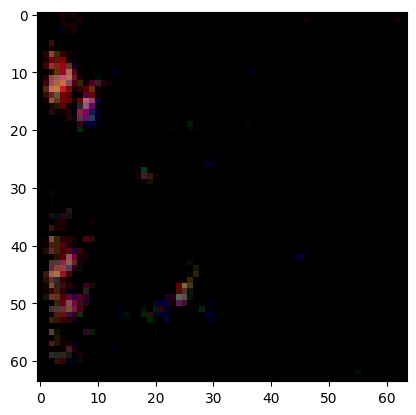

Epoch 32 / 50 - Gan Loss 0.7604077370264664 | Discr loss 0.38965343208386727 


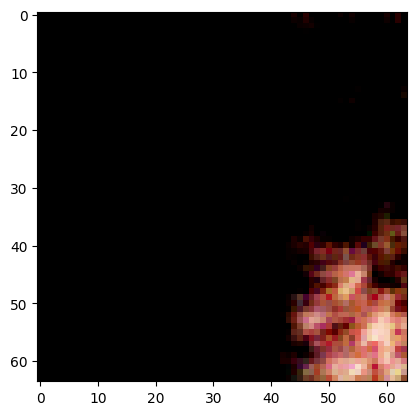

Epoch 33 / 50 - Gan Loss 1.4076633307951048 | Discr loss 0.5314603364610856 


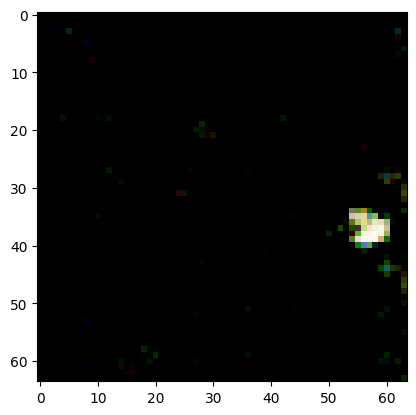

Epoch 34 / 50 - Gan Loss 1.2731486112800132 | Discr loss 0.2698868296330734 


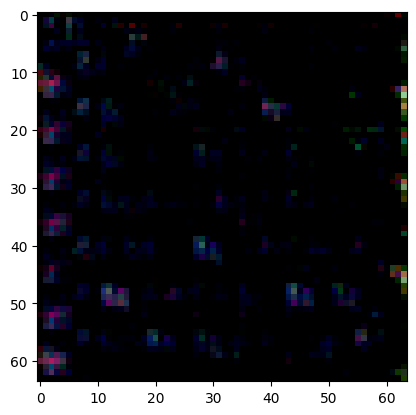

Epoch 35 / 50 - Gan Loss 0.7314709459600062 | Discr loss 0.3534205679919103 


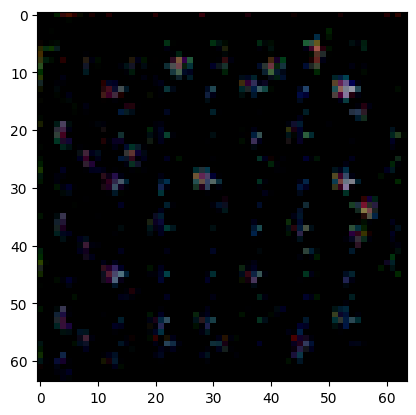

Epoch 36 / 50 - Gan Loss 1.1029633776503105 | Discr loss 0.23424265253903528 


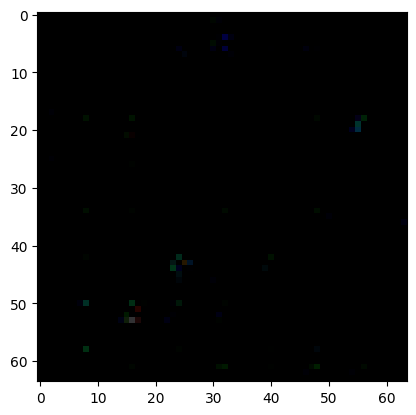

Epoch 37 / 50 - Gan Loss 0.9819093441012744 | Discr loss 0.6003128576233888 


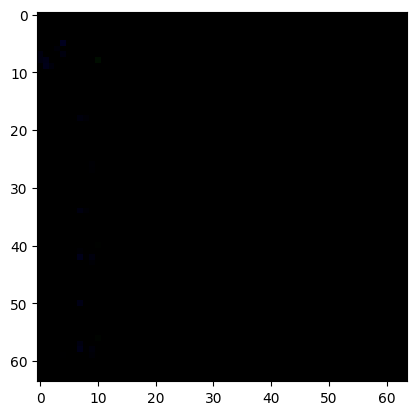

Epoch 38 / 50 - Gan Loss 1.1402514028016653 | Discr loss 0.4686923475458605 


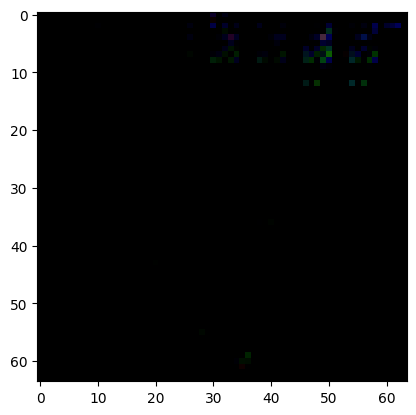

Epoch 39 / 50 - Gan Loss 0.5289185402858673 | Discr loss 0.23803081905417814 


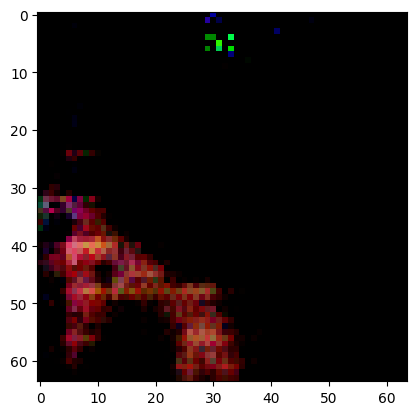

Epoch 40 / 50 - Gan Loss 1.2063516794013798 | Discr loss 0.5398127850899591 


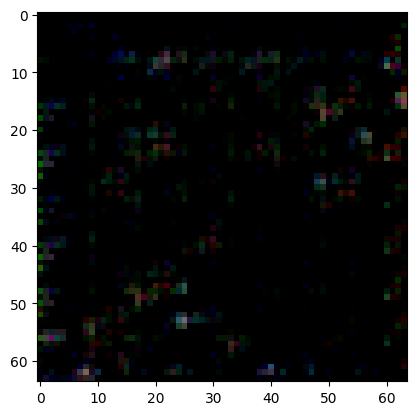

Epoch 41 / 50 - Gan Loss 0.7440178032408684 | Discr loss 0.27456148931166435 


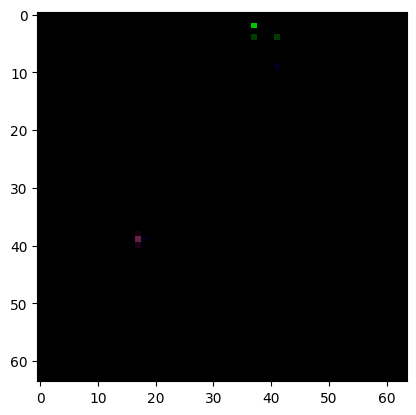

Epoch 42 / 50 - Gan Loss 1.2003081041942714 | Discr loss 0.4018920523541297 


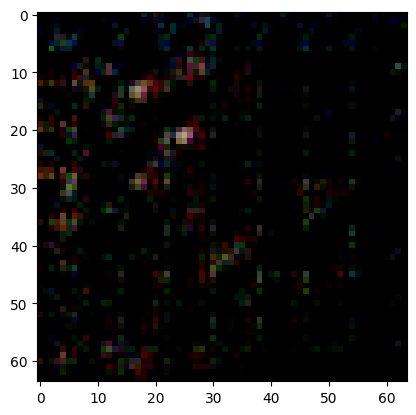

Epoch 43 / 50 - Gan Loss 0.5345344035697445 | Discr loss 0.31045169877776246 


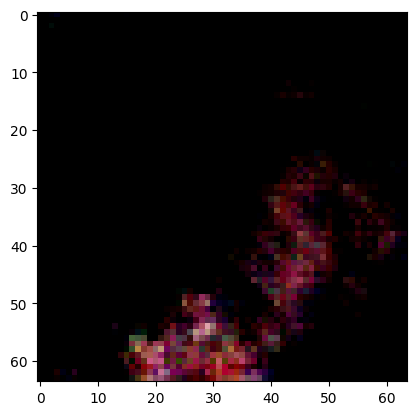

Epoch 44 / 50 - Gan Loss 0.6282706239920581 | Discr loss 0.37934254661138456 


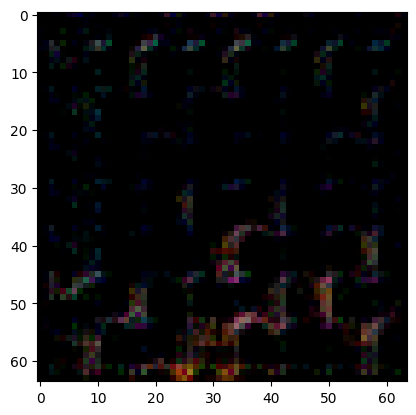

Epoch 45 / 50 - Gan Loss 0.3511015071696862 | Discr loss 0.3093926370489452 


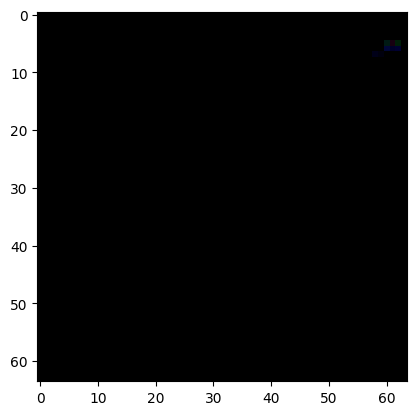

Epoch 46 / 50 - Gan Loss 1.1963165952425419 | Discr loss 0.47248891465214105 


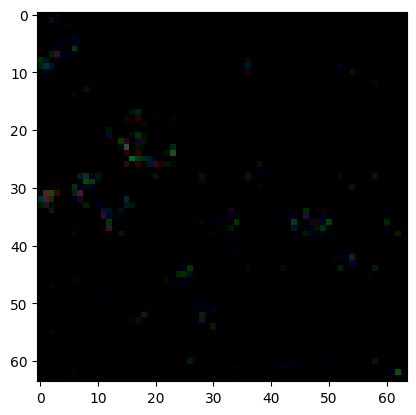

Epoch 47 / 50 - Gan Loss 0.6324461131956522 | Discr loss 0.23348282550123373 


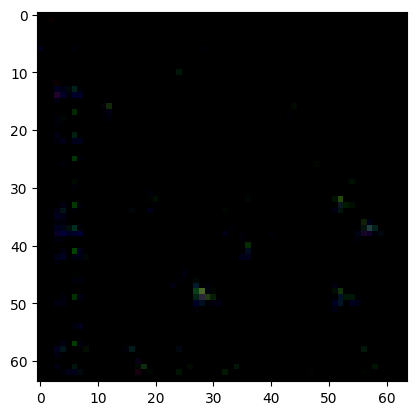

Epoch 48 / 50 - Gan Loss 0.5178082895432016 | Discr loss 0.21432264974987447 


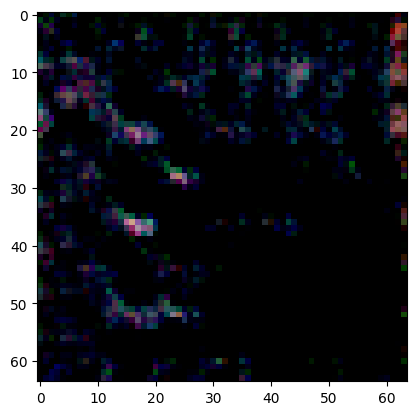

Epoch 49 / 50 - Gan Loss 1.156973283100939 | Discr loss 0.26303382341129933 


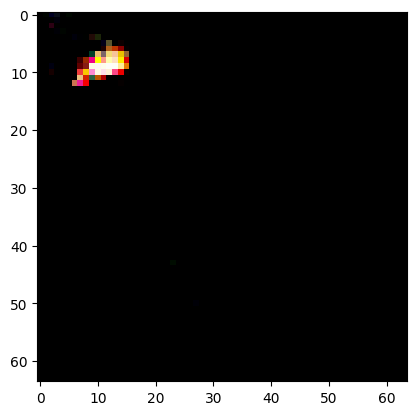

Epoch 50 / 50 - Gan Loss 2.0028466133363763 | Discr loss 0.42339253395301607 


In [25]:
trained_gan = train_gan(gan_model=gan_model, dataset=x_train_gan, codings_size=CODINGS_SIZE, epochs=50)

In [26]:
name = 'GAN'
artifacts_path = model_save_fp / Path(name)
trained_gan.save(artifacts_path)
_log.info(f"Saved {trained_gan.name} in folder {artifacts_path}")

INFO:tensorflow:Assets written to: /root/deeplearning/trained_models/eurosat/GAN/assets


INFO:tensorflow:Assets written to: /root/deeplearning/trained_models/eurosat/GAN/assets


Making predictions

In [27]:
name = 'GAN'
artifacts_path = model_save_fp / Path(name)
trained_gan = tf.keras.models.load_model(artifacts_path)

1/1 [==============================] - 0s 232ms/step


TypeError: Invalid shape (1,) for image data

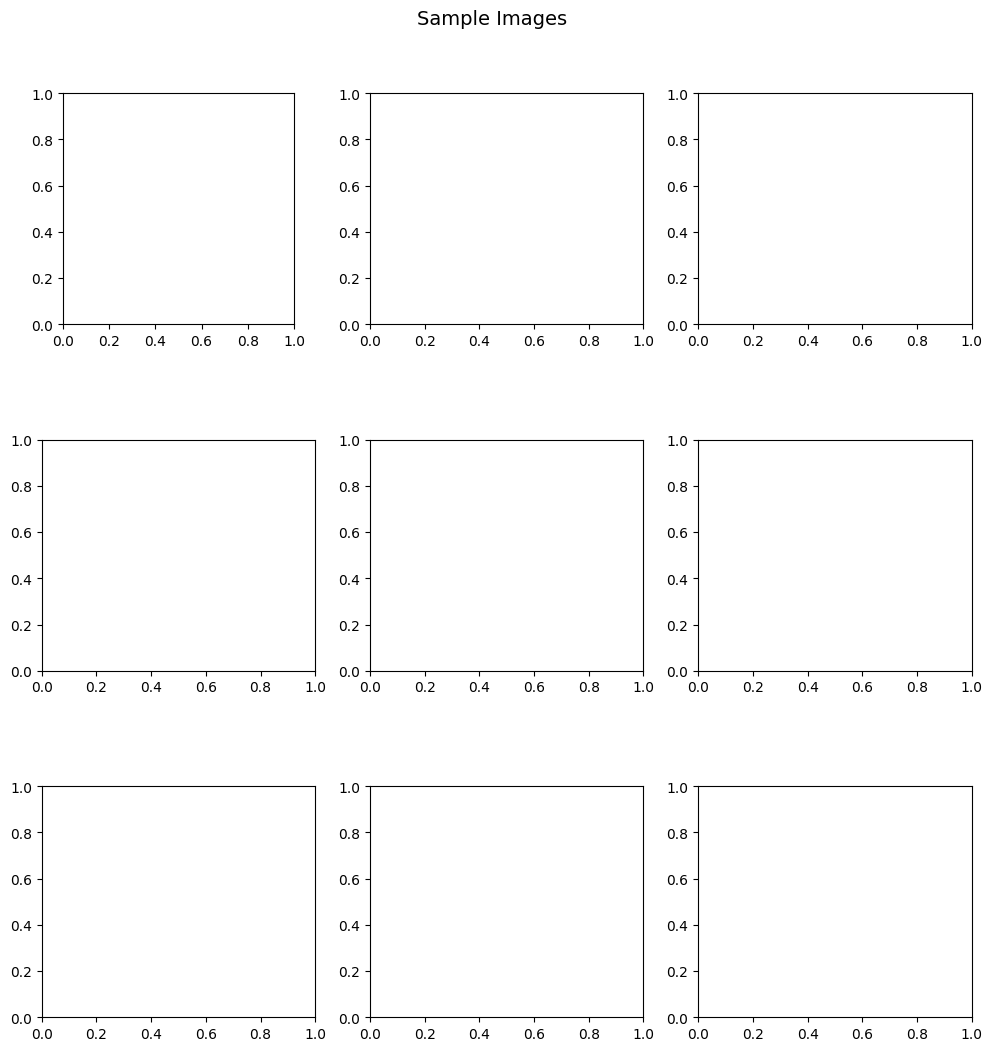

In [30]:
plot_random_images(trained_gan, 100, 9)